In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import r2_score,mean_squared_error
from xgboost import plot_importance
!pip install xgboost
!pip install lightgbm

In [2]:
salesdf = pd.read_csv('sales_prediction.csv')

In [3]:
salesdf.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
print(salesdf.isnull().sum())

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [5]:
#Splitting the input and output columns
X = salesdf.drop(columns=['Item_Outlet_Sales'])
Y = salesdf['Item_Outlet_Sales']

In [6]:
#Splitting the data into Test and Train

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [7]:
X_train.shape, X_test.shape

((5966, 11), (2557, 11))

In [8]:
#making a copy of the data for exploration

X_train_c = X_train.copy()

In [9]:
X_train_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5966 entries, 1921 to 7270
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5966 non-null   object 
 1   Item_Weight                4943 non-null   float64
 2   Item_Fat_Content           5966 non-null   object 
 3   Item_Visibility            5966 non-null   float64
 4   Item_Type                  5966 non-null   object 
 5   Item_MRP                   5966 non-null   float64
 6   Outlet_Identifier          5966 non-null   object 
 7   Outlet_Establishment_Year  5966 non-null   int64  
 8   Outlet_Size                4276 non-null   object 
 9   Outlet_Location_Type       5966 non-null   object 
 10  Outlet_Type                5966 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 559.3+ KB


In [10]:
X_train_c.isnull().sum()

Item_Identifier                 0
Item_Weight                  1023
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1690
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [11]:
#Excluding the object data type

num_data = X_train_c.select_dtypes(exclude=['object'])
num_data.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
1921,7.72,0.147904,116.6466,1998
655,19.75,0.014301,103.0332,1997
2229,NaN,0.054221,129.1310,1985
2537,19.35,0.118342,222.6088,2002
3528,18.35,0.092150,184.8266,1987


In [12]:
num_data.describe().round(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,4943.000,5966.000,5966.000,5966.000
mean,12.937,0.066,141.814,1997.867
std,4.630,0.051,62.628,8.385
min,4.555,0.000,31.290,1985.000
25%,8.895,0.027,94.144,1987.000
50%,12.650,0.054,143.880,1999.000
75%,17.000,0.094,186.621,2004.000
max,21.350,0.328,266.888,2009.000


In [13]:
num_data.isnull().sum()

Item_Weight                  1023
Item_Visibility                 0
Item_MRP                        0
Outlet_Establishment_Year       0
dtype: int64

<AxesSubplot:xlabel='Item_Weight', ylabel='Count'>

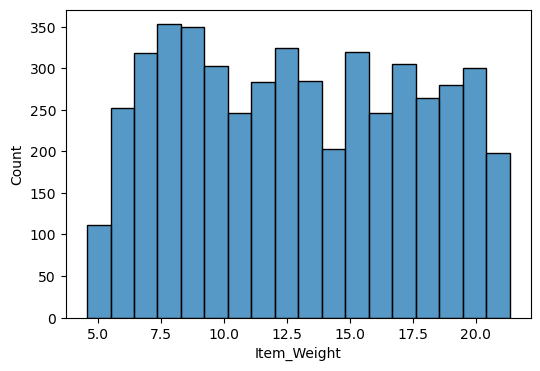

In [14]:
plt.figure(figsize=(6,4))
sns.histplot(data=X_train_c, x='Item_Weight')

<AxesSubplot:ylabel='Item_Weight'>

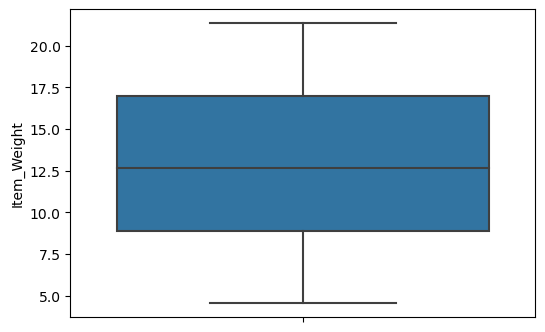

In [15]:
plt.figure(figsize=(6,4))
sns.boxplot(data=X_train_c, y='Item_Weight')

In [16]:
#defining a function

def visualize_numeric_feature(data_frame, col_name):
    fig,ax = plt.subplots(1,2, figsize=(12,5))
    sns.histplot(data=data_frame, x=col_name, ax=ax[0]);
    sns.boxplot(data=data_frame, y=col_name, ax=ax[1]);

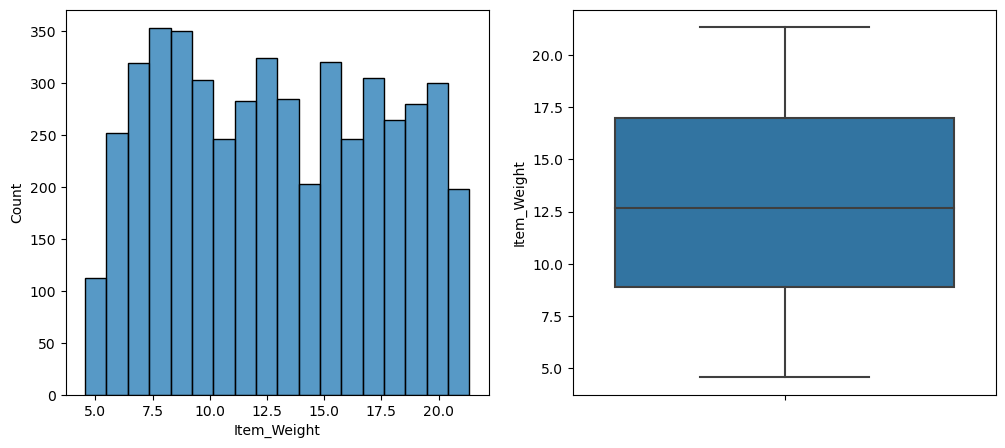

In [17]:
visualize_numeric_feature(X_train_c, 'Item_Weight')

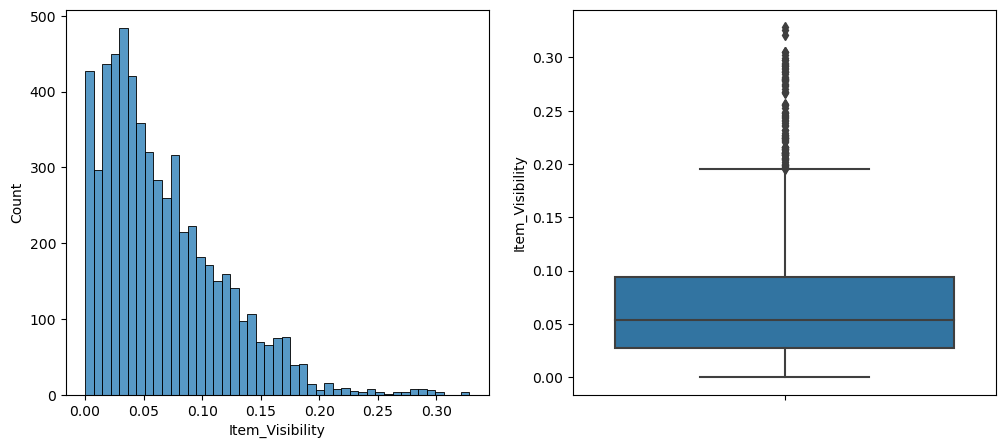

In [18]:
visualize_numeric_feature(X_train_c, 'Item_Visibility')

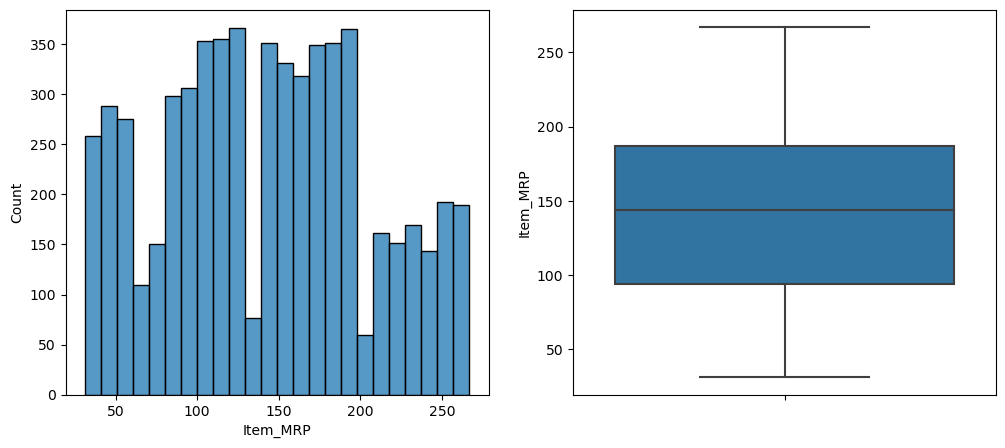

In [19]:
visualize_numeric_feature(X_train_c, 'Item_MRP')

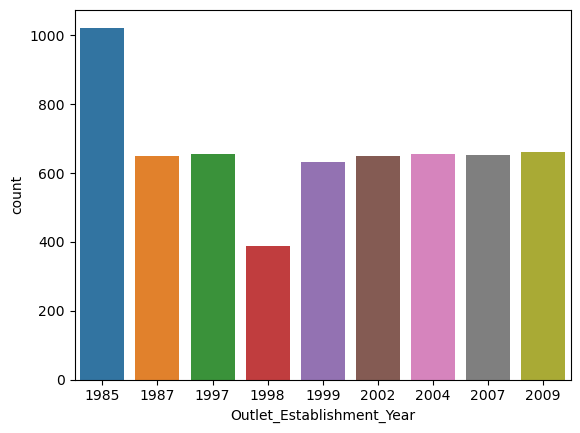

In [20]:
sns.countplot(data=X_train_c, x='Outlet_Establishment_Year');

In [21]:
#Categorical feautures
cat_features = X_train_c.select_dtypes(include=['object'])
cat_features.head()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
1921,FDN08,Regular,Fruits and Vegetables,OUT010,NaN,Tier 3,Grocery Store
655,NCJ42,Low Fat,Household,OUT046,Small,Tier 1,Supermarket Type1
2229,FDY47,Regular,Breads,OUT027,Medium,Tier 3,Supermarket Type3
2537,FDN45,Low Fat,Snack Foods,OUT045,NaN,Tier 2,Supermarket Type1
3528,FDY16,Regular,Frozen Foods,OUT013,High,Tier 3,Supermarket Type1


In [22]:
cat_features.describe()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,5966,5966,5966,5966,4276,5966,5966
unique,1543,5,16,10,3,3,4
top,NCI54,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,9,3535,905,668,1960,2367,3893


In [23]:
cat_features.isnull().sum()

Item_Identifier            0
Item_Fat_Content           0
Item_Type                  0
Outlet_Identifier          0
Outlet_Size             1690
Outlet_Location_Type       0
Outlet_Type                0
dtype: int64

In [24]:
cat_features['Item_Identifier'].value_counts()

NCI54    9
FDF52    9
FDV60    8
FDT07    8
NCB18    8
        ..
FDT47    1
NCW42    1
DRH59    1
FDV14    1
FDG28    1
Name: Item_Identifier, Length: 1543, dtype: int64

In [25]:
cat_features['Item_Fat_Content'].value_counts()

Low Fat    3535
Regular    2027
LF          243
low fat      82
reg          79
Name: Item_Fat_Content, dtype: int64

In [26]:
cat_features['Item_Type'].value_counts()

Fruits and Vegetables    905
Snack Foods              835
Household                648
Frozen Foods             591
Dairy                    474
Canned                   450
Baking Goods             438
Health and Hygiene       365
Soft Drinks              305
Meat                     275
Hard Drinks              162
Breads                   159
Others                   124
Starchy Foods            116
Breakfast                 80
Seafood                   39
Name: Item_Type, dtype: int64

In [27]:
cat_features['Outlet_Identifier'].value_counts()

OUT027    668
OUT018    661
OUT046    656
OUT035    656
OUT017    652
OUT045    649
OUT013    649
OUT049    631
OUT010    389
OUT019    355
Name: Outlet_Identifier, dtype: int64

In [28]:
cat_features['Outlet_Size'].value_counts()

Medium    1960
Small     1667
High       649
Name: Outlet_Size, dtype: int64

In [29]:
cat_features['Outlet_Location_Type'].value_counts()

Tier 3    2367
Tier 2    1957
Tier 1    1642
Name: Outlet_Location_Type, dtype: int64

In [30]:
cat_features['Outlet_Type'].value_counts()

Supermarket Type1    3893
Grocery Store         744
Supermarket Type3     668
Supermarket Type2     661
Name: Outlet_Type, dtype: int64

<h1> Data Wrangling + Feature Engineering

<h3> Creating a High Level Item Type

In [31]:
X_train_c['Item_Identifier'].apply(lambda x:x[:2]).value_counts()

FD    4269
NC    1137
DR     560
Name: Item_Identifier, dtype: int64

In [32]:
#Step 1: Map the Item IDs to Item Types

def create_item_type(data_frame):
    data_frame['Item_Type'] = data_frame['Item_Identifier'].str[:2]
    data_frame['Item_Type'] = data_frame['Item_Type'].map({
        														'FD' : 'Food',
                                                                'NC' : 'Non_Consumables',
                                                                'DR' : 'Drinks'})
    return data_frame

In [33]:
X_train_c = create_item_type(X_train_c)
X_train_c.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
1921,FDN08,7.72,Regular,0.147904,Food,116.6466,OUT010,1998,NaN,Tier 3,Grocery Store
655,NCJ42,19.75,Low Fat,0.014301,Non_Consumables,103.0332,OUT046,1997,Small,Tier 1,Supermarket Type1
2229,FDY47,NaN,Regular,0.054221,Food,129.1310,OUT027,1985,Medium,Tier 3,Supermarket Type3
2537,FDN45,19.35,Low Fat,0.118342,Food,222.6088,OUT045,2002,NaN,Tier 2,Supermarket Type1
3528,FDY16,18.35,Regular,0.092150,Food,184.8266,OUT013,1987,High,Tier 3,Supermarket Type1


In [34]:
#Step 2 Filling in missing values for Item_weight

X_train_c.isnull().sum()

Item_Identifier                 0
Item_Weight                  1023
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1690
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [35]:
X_train_c[['Item_Type','Item_Weight']].drop_duplicates().sort_values(by=['Item_Type'])

,Item_Type,Item_Weight
2796,Drinks,5.730
998,Drinks,20.250
670,Drinks,8.395
6091,Drinks,13.500
3438,Drinks,13.850
...,...,...
6624,Non_Consumables,12.600
6191,Non_Consumables,8.880
1911,Non_Consumables,19.850
135,Non_Consumables,7.235


In [36]:
#Step 2 : Fill in the missing values for Item_Weight
#Logic
#1st Step : Use mapping of Item ID - weight and fill in missing values
#2nd Step : If completely new item - median (weight) and fill in the missing values

ITEM_ID_WEIGHT_PIVOT = X_train_c.pivot_table(values = 'Item_Weight', index='Item_Identifier').reset_index()
ITEM_ID_WEIGHT_MAPPING = dict(zip(ITEM_ID_WEIGHT_PIVOT['Item_Identifier'],ITEM_ID_WEIGHT_PIVOT['Item_Weight']))
list(ITEM_ID_WEIGHT_MAPPING.items())[:10]

[('DRA12', 11.6),
 ('DRA24', 19.35),
 ('DRA59', 8.27),
 ('DRB01', 7.39),
 ('DRB13', 6.115),
 ('DRB24', 8.785),
 ('DRB25', 12.300000000000002),
 ('DRB48', 16.75),
 ('DRC01', 5.92),
 ('DRC12', 17.85)]

In [37]:
ITEM_TYPE_WEIGHT_PIVOT = X_train_c.pivot_table(values = 'Item_Weight', index = 'Item_Type',
                                              aggfunc= 'median').reset_index()
ITEM_ID_WEIGHT_MAPPING = dict(zip(ITEM_TYPE_WEIGHT_PIVOT['Item_Type'],ITEM_TYPE_WEIGHT_PIVOT['Item_Weight']))
list(ITEM_ID_WEIGHT_MAPPING.items())

[('Drinks', 11.8), ('Food', 12.8), ('Non_Consumables', 13.05)]

In [38]:
def impute_item_weight(data_frame):
    #1st logic item id - weight
    data_frame.loc[:,'Item_Weight']=data_frame.loc[:,'Item_Weight'].fillna(data_frame.loc[:,'Item_Identifier'].map(ITEM_ID_WEIGHT_MAPPING))
    #2nd Logic Item type - weight if any still missing
    data_frame.loc[:,'Item_Weight']=data_frame.loc[:,'Item_Weight'].fillna(data_frame.loc[:,'Item_Type'].map(ITEM_ID_WEIGHT_MAPPING))
    
    return data_frame

In [39]:
X_train_c = impute_item_weight(X_train_c)
X_train_c.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1690
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

<h2> Step 3 : Fill in the missing values of Outlet_Size

In [40]:
X_train_c.groupby(by=['Outlet_Type', 'Outlet_Size']).size()

Outlet_Type        Outlet_Size
Grocery Store      Small           355
Supermarket Type1  High            649
                   Medium          631
                   Small          1312
Supermarket Type2  Medium          661
Supermarket Type3  Medium          668
dtype: int64

In [41]:
X_train_c.loc[(X_train_c['Outlet_Type'] == 'Grocery Store') & (X_train_c['Outlet_Size'].isnull()), 'Outlet_Size'] = 'Small'

X_train_c

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
1921,FDN08,7.720,Regular,0.147904,Food,116.6466,OUT010,1998,Small,Tier 3,Grocery Store
655,NCJ42,19.750,Low Fat,0.014301,Non_Consumables,103.0332,OUT046,1997,Small,Tier 1,Supermarket Type1
2229,FDY47,12.800,Regular,0.054221,Food,129.1310,OUT027,1985,Medium,Tier 3,Supermarket Type3
2537,FDN45,19.350,Low Fat,0.118342,Food,222.6088,OUT045,2002,NaN,Tier 2,Supermarket Type1
3528,FDY16,18.350,Regular,0.092150,Food,184.8266,OUT013,1987,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...,...,...,...,...
5734,FDY08,9.395,Regular,0.286345,Food,139.1838,OUT010,1998,Small,Tier 3,Grocery Store
5191,FDC41,15.600,Low Fat,0.117575,Food,75.6670,OUT017,2007,NaN,Tier 2,Supermarket Type1
5390,NCQ53,17.600,Low Fat,0.018944,Non_Consumables,237.3590,OUT045,2002,NaN,Tier 2,Supermarket Type1
860,FDL46,20.350,low fat,0.054363,Food,117.9466,OUT017,2007,NaN,Tier 2,Supermarket Type1


In [42]:
#Logic
#1st step : Use mapping of Outlet_type  - mode(Outlet_size)

OUTLET_TYPE_SIZE_PIVOT = X_train_c.pivot_table(values='Outlet_Size', index = 'Outlet_Type',
                       aggfunc=(lambda x:mode(x).mode[0])).reset_index()
OUTLET_TYPE_SIZE_MAPPING = dict(zip(OUTLET_TYPE_SIZE_PIVOT['Outlet_Type'],OUTLET_TYPE_SIZE_PIVOT['Outlet_Size']))
OUTLET_TYPE_SIZE_MAPPING

C:\Users\Valued Customer\AppData\Local\Temp\ipykernel_75252\2459193205.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  aggfunc=(lambda x:mode(x).mode[0])).reset_index()
C:\Users\Public\Anaconda\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


{'Grocery Store': 'Small',
 'Supermarket Type1': 'Small',
 'Supermarket Type2': 'Medium',
 'Supermarket Type3': 'Medium'}

In [43]:
def impute_outlet_size(data_frame):
    #1st Logic outlet_type - mode(Outlet_Size)
    data_frame.loc[:,'Outlet_Size'] = data_frame.loc[:,'Outlet_Size'].fillna(data_frame.loc[:,'Outlet_Type'].map(OUTLET_TYPE_SIZE_MAPPING))
    
    return data_frame

In [44]:
X_train_c = impute_outlet_size(X_train_c)

In [45]:
X_train_c.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

<h2> Step 4: Standardize Item_Fat_Content categories

In [46]:
X_train_c ['Item_Fat_Content'].value_counts()

Low Fat    3535
Regular    2027
LF          243
low fat      82
reg          79
Name: Item_Fat_Content, dtype: int64

In [47]:
def standardize_item_fat_content(data_frame):
    data_frame['Item_Fat_Content'] = data_frame['Item_Fat_Content'].replace({ 
        						'Low Fat' :'Low_Fat',
        						'reg':'Regular',
        						'low fat':'Low_Fat',
        						'LF' : 'Low_Fat'
    })
    return data_frame

In [48]:
X_train_c = standardize_item_fat_content(X_train_c)
X_train_c ['Item_Fat_Content'].value_counts()

Low_Fat    3860
Regular    2106
Name: Item_Fat_Content, dtype: int64

<h2> Step : Correct Item Fat Content for Non-consumables

In [49]:
#Grouping Item_Type with Item_Fat_Content
X_train_c.groupby(by=['Item_Type','Item_Fat_Content']).size()

Item_Type        Item_Fat_Content
Drinks           Low_Fat              517
                 Regular               43
Food             Low_Fat             2206
                 Regular             2063
Non_Consumables  Low_Fat             1137
dtype: int64

In [50]:
#Checking Item_Fat_Content for Non_Consumables

X_train_c.loc[X_train_c['Item_Type'] == 'Non_Consumables','Item_Fat_Content']

655     Low_Fat
4423    Low_Fat
907     Low_Fat
7021    Low_Fat
6074    Low_Fat
         ...   
8322    Low_Fat
466     Low_Fat
6265    Low_Fat
5390    Low_Fat
7270    Low_Fat
Name: Item_Fat_Content, Length: 1137, dtype: object

In [51]:
#Step 5 : COrrect  Item Fat Content for Non-COnsumables

def correct_item_fat_content(data_frame):
    data_frame.loc[data_frame['Item_Type'] == 'Non_Consumables','Item_Fat_Content'] = 'Non_Edible'
    return data_frame

In [52]:
X_train_c = correct_item_fat_content(X_train_c)
X_train_c.groupby(by = ['Item_Type','Item_Fat_Content']).size()

Item_Type        Item_Fat_Content
Drinks           Low_Fat              517
                 Regular               43
Food             Low_Fat             2206
                 Regular             2063
Non_Consumables  Non_Edible          1137
dtype: int64

In [53]:
X_train_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5966 entries, 1921 to 7270
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5966 non-null   object 
 1   Item_Weight                5966 non-null   float64
 2   Item_Fat_Content           5966 non-null   object 
 3   Item_Visibility            5966 non-null   float64
 4   Item_Type                  5966 non-null   object 
 5   Item_MRP                   5966 non-null   float64
 6   Outlet_Identifier          5966 non-null   object 
 7   Outlet_Establishment_Year  5966 non-null   int64  
 8   Outlet_Size                5966 non-null   object 
 9   Outlet_Location_Type       5966 non-null   object 
 10  Outlet_Type                5966 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 559.3+ KB


<h1> Prepare Dataset for ML

In [54]:
def prepare_dataset(data_frame):
    
    #Step 1 : Create Item Type
    data_frame = create_item_type(data_frame)
    
    #Step 2: Fill in missing values for Item_Weight
    data_frame = impute_item_weight(data_frame)
    
    #Step 3: Impute missing values for Outlet_Size
    data_frame = impute_outlet_size(data_frame)
    
    #Step 4 : Make Item Fat Content categories consistent
    data_frame = standardize_item_fat_content(data_frame)
    
    #Step 5 : Correct Item Fat content for non-consumables
    data_frame = correct_item_fat_content(data_frame)
    
    return data_frame

In [55]:
X_train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1023
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1690
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [56]:
X_train= prepare_dataset(X_train)
X_train.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [57]:
X_test.isnull().sum()

Item_Identifier                0
Item_Weight                  440
Item_Fat_Content               0
Item_Visibility                0
Item_Type                      0
Item_MRP                       0
Outlet_Identifier              0
Outlet_Establishment_Year      0
Outlet_Size                  720
Outlet_Location_Type           0
Outlet_Type                    0
dtype: int64

In [58]:
X_test= prepare_dataset(X_test)
X_test.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

<h1> Handling Categorical Data

<h3> All Categorical Columns - One hot encoded

In [59]:
cat_features = X_train.select_dtypes(include = ['object'])
cat_features.head()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
1921,FDN08,Regular,Food,OUT010,Small,Tier 3,Grocery Store
655,NCJ42,Non_Edible,Non_Consumables,OUT046,Small,Tier 1,Supermarket Type1
2229,FDY47,Regular,Food,OUT027,Medium,Tier 3,Supermarket Type3
2537,FDN45,Low_Fat,Food,OUT045,Small,Tier 2,Supermarket Type1
3528,FDY16,Regular,Food,OUT013,High,Tier 3,Supermarket Type1


In [60]:
#Ignore Unknown Categories and Fit in cat_features

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown = 'ignore')
ohe.fit(cat_features)

OneHotEncoder(handle_unknown='ignore')

In [61]:
#Make Categories of for each column

ohe_features_names = ohe.get_feature_names_out(input_features= cat_features.columns)
ohe_features_names

array(['Item_Identifier_DRA12', 'Item_Identifier_DRA24',
       'Item_Identifier_DRA59', ..., 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'],
      dtype=object)

In [62]:
#check the non Catrgorical features

num_features_train = X_train.select_dtypes(exclude = ['object']).reset_index(drop=True)
num_features_train.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
0,7.72,0.147904,116.6466,1998
1,19.75,0.014301,103.0332,1997
2,12.80,0.054221,129.1310,1985
3,19.35,0.118342,222.6088,2002
4,18.35,0.092150,184.8266,1987


In [63]:
cat_features_train = X_train.select_dtypes(include = ['object'])
X_train_cat_ohe = pd.DataFrame(ohe.transform(cat_features_train).toarray(),columns=ohe_features_names)
X_train_cat_ohe.head()

,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,Item_Identifier_DRB25,Item_Identifier_DRB48,Item_Identifier_DRC01,Item_Identifier_DRC12,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [64]:
X_train_final = pd.concat([num_features_train,X_train_cat_ohe],axis=1)
X_train_final.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,7.72,0.147904,116.6466,1998,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,19.75,0.014301,103.0332,1997,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,12.80,0.054221,129.1310,1985,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,19.35,0.118342,222.6088,2002,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,18.35,0.092150,184.8266,1987,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [65]:
final_columns = X_train_final.columns.values

In [66]:
final_columns

array(['Item_Weight', 'Item_Visibility', 'Item_MRP', ...,
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'], dtype=object)

In [67]:
#Seprate the data types and transform the categorical features and concatinating num_features_test with X_tes_cat_ohe

num_features_test = X_test.select_dtypes(exclude= ['object']).reset_index(drop=True)
cat_features_test = X_test.select_dtypes(include= ['object'])
X_test_cat_ohe = pd.DataFrame(ohe.transform(cat_features_test).toarray(),columns=ohe_features_names)
X_test_final = pd.concat([num_features_test,X_test_cat_ohe],axis=1)
X_test_final = X_test_final[final_columns]

X_test_final.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,14.300,0.026300,79.4302,1987,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,7.930,0.071136,42.7086,1997,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,14.500,0.041313,42.0454,1999,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,11.800,0.044767,173.7054,1985,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,10.195,0.012456,197.5110,2004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [68]:
X_test_final.shape

(2557, 1573)

<h2> Modeling

<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Count'>

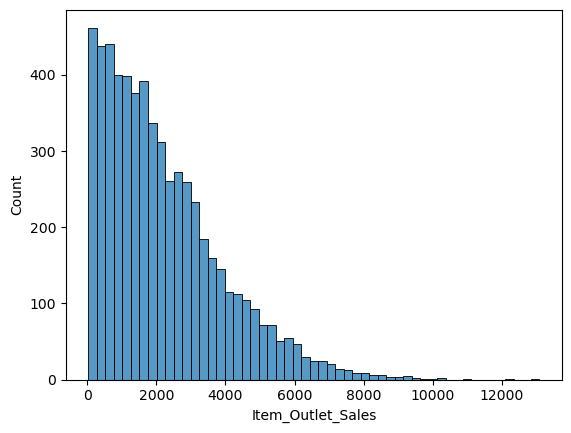

In [69]:
sns.histplot(Y_train)

In [70]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate

In [71]:
def train_and_eval_model(model,X_train,Y_train, cv = 5):
    cv_results = cross_validate(model,X_train,Y_train, cv = cv, scoring = ('r2','neg_root_mean_squared_error'),)
    print ('Model',model)
    r2_scores = cv_results['test_r2']
    print('R2 CV Scores:', r2_scores)
    print('R2 CV scores mean / stdev:', np.mean(r2_scores), '/', np.std(r2_scores))
    
    rmse_scores = cv_results['test_neg_root_mean_squared_error']
    rmse_scores = [-1*score for score in rmse_scores]
    print('RMSE CV Scores:', rmse_scores)
    print('RMSE CV Scores mean / stdev:', np.mean(rmse_scores),'/',np.std(rmse_scores))

<h2> Handling Categorical Data without Item_Identifier - One hot Encoded

In [72]:
cat_feats = X_train.select_dtypes(include=['object']).drop(columns = 'Item_Identifier')
ohe = OneHotEncoder(handle_unknown = 'ignore')
ohe.fit(cat_feats)
ohe_feature_names = ohe.get_feature_names_out(input_features = cat_feats.columns)

In [73]:
num_feats_train = X_train.select_dtypes(exclude=['object']).reset_index(drop=True)
cat_feats_train = X_train.select_dtypes(include=['object']).drop(columns = ['Item_Identifier'])
X_train_cat_ohe = pd.DataFrame(ohe.transform(cat_feats_train).toarray(),columns=ohe_feature_names)
X_train_final = pd.concat([num_feats_train, X_train_cat_ohe], axis=1)

X_train_final.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low_Fat,Item_Fat_Content_Non_Edible,Item_Fat_Content_Regular,Item_Type_Drinks,Item_Type_Food,Item_Type_Non_Consumables,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,7.72,0.147904,116.6466,1998,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,19.75,0.014301,103.0332,1997,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,12.80,0.054221,129.1310,1985,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,19.35,0.118342,222.6088,2002,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,18.35,0.092150,184.8266,1987,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [74]:
X_train_final.shape

(5966, 30)

In [75]:
SEED=42
gb = GradientBoostingRegressor(random_state= SEED)
train_and_eval_model(model=gb, X_train=X_train_final, Y_train=Y_train)

Model GradientBoostingRegressor(random_state=42)
R2 CV Scores: [0.6041804  0.58438048 0.58762463 0.62389778 0.57481794]
R2 CV scores mean / stdev: 0.5949802453520936 / 0.01728493581675094
RMSE CV Scores: [1060.0266792918649, 1095.0929737973222, 1121.2510747873034, 1060.3776729426581, 1131.57085634834]
RMSE CV Scores mean / stdev: 1093.6638514334977 / 29.797541284231123


In [76]:
hgb = HistGradientBoostingRegressor(random_state=SEED)
train_and_eval_model(model=hgb, X_train=X_train_final, Y_train=Y_train)

Model HistGradientBoostingRegressor(random_state=42)
R2 CV Scores: [0.58815491 0.54895006 0.55004131 0.58665649 0.54418843]
R2 CV scores mean / stdev: 0.5635982423744614 / 0.019543864873815386
RMSE CV Scores: [1081.2723378509593, 1140.8152997438422, 1171.231744842289, 1111.6374875671404, 1171.6204952410717]
RMSE CV Scores mean / stdev: 1135.3154730490605 / 34.98453592112486


In [77]:
xgr = xgb.XGBRegressor(objective = 'reg:squarederror', rnadom_state=SEED)
train_and_eval_model(model=xgr, X_train=X_train_final, Y_train=Y_train)

[08:30:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "rnadom_state" } are not used.

[08:30:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "rnadom_state" } are not used.

[08:30:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "rnadom_state" } are not used.

[08:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "rnadom_state" } are not used.

[08:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "rnadom_state" } are n

In [78]:
lgbr = LGBMRegressor(random_state = SEED)
train_and_eval_model(model=lgbr, X_train=X_train_final, Y_train=Y_train)

Model LGBMRegressor(random_state=42)
R2 CV Scores: [0.58585451 0.55844792 0.55401427 0.59124072 0.53449858]
R2 CV scores mean / stdev: 0.5648112001928395 / 0.021058302012837954
RMSE CV Scores: [1084.2879125560519, 1128.7401894490577, 1166.04952316014, 1105.455937304808, 1184.0084312547822]
RMSE CV Scores mean / stdev: 1133.708398744968 / 36.99002766992896


In [79]:
xgr = xgb.XGBRegressor(objective = 'reg:squarederror', rnadom_state=SEED)
xgr.fit(X_train_final, Y_train)

[08:30:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "rnadom_state" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<h1> Handling Categorical Data with Vectors

In [80]:
X_train['Item_Identifier'].head()

1921    FDN08
655     NCJ42
2229    FDY47
2537    FDN45
3528    FDY16
Name: Item_Identifier, dtype: object

In [81]:
hash_vector_size = 50
fh = FeatureHasher(n_features=hash_vector_size, input_type='string')
hashed_df = pd.DataFrame(fh.transform(X_train['Item_Identifier']).toarray(),
                        columns = ['H'+str(i) for i in range(hash_vector_size)])
hashed_df.head()

,H0,H1,H2,H3,H4,H5,H6,H7,H8,H9,...,H40,H41,H42,H43,H44,H45,H46,H47,H48,H49
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
cat_feats = X_train.select_dtypes(include = ['object']).drop(columns = ['Item_Identifier'])
ohe = OneHotEncoder(handle_unknown = 'ignore')
ohe.fit(cat_feats)
ohe_feature_names = ohe.get_feature_names_out(input_features=cat_feats.columns)

In [83]:
num_feats_train = X_train.select_dtypes(exclude=['object']).reset_index(drop=True)
cat_feats_train = X_train.select_dtypes(include=['object']).drop(columns = ['Item_Identifier'])
X_train_cat_ohe = pd.DataFrame(ohe.transform(cat_feats_train).toarray(),columns=ohe_feature_names)
X_train_final = pd.concat([num_feats_train, hashed_df, X_train_cat_ohe], axis=1)

X_train_final.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,H0,H1,H2,H3,H4,H5,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,7.72,0.147904,116.6466,1998,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,19.75,0.014301,103.0332,1997,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,12.80,0.054221,129.1310,1985,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,19.35,0.118342,222.6088,2002,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,18.35,0.092150,184.8266,1987,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [84]:
gb = GradientBoostingRegressor(random_state= SEED)
train_and_eval_model(model=gb, X_train=X_train_final, Y_train=Y_train)

Model GradientBoostingRegressor(random_state=42)
R2 CV Scores: [0.60855875 0.587366   0.5810046  0.62783138 0.57510432]
R2 CV scores mean / stdev: 0.5959730112193707 / 0.019529425464717563
RMSE CV Scores: [1054.1476399474934, 1091.1526815140976, 1130.2151935656525, 1054.8179293497578, 1131.1897115703541]
RMSE CV Scores mean / stdev: 1092.3046311894711 / 34.09338938686088


In [85]:
hgb = HistGradientBoostingRegressor(random_state=SEED)
train_and_eval_model(model=hgb, X_train=X_train_final, Y_train=Y_train)

Model HistGradientBoostingRegressor(random_state=42)
R2 CV Scores: [0.5764088  0.5491504  0.54524293 0.59281047 0.54521676]
R2 CV scores mean / stdev: 0.5617658726723558 / 0.019412435321322037
RMSE CV Scores: [1096.5832593271898, 1140.5619137375313, 1177.4602214750348, 1103.3312665361711, 1170.2981415593495]
RMSE CV Scores mean / stdev: 1137.6469605270554 / 33.2369876271682


In [86]:
xgr = xgb.XGBRegressor(objective = 'reg:squarederror', rnadom_state=SEED)
train_and_eval_model(model=xgr, X_train=X_train_final, Y_train=Y_train)

[08:30:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "rnadom_state" } are not used.

[08:30:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "rnadom_state" } are not used.

[08:30:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "rnadom_state" } are not used.

[08:30:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "rnadom_state" } are not used.

[08:30:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "rnadom_state" } are n

In [87]:
lgbr = LGBMRegressor(random_state = SEED)
train_and_eval_model(model=lgbr, X_train=X_train_final, Y_train=Y_train)

Model LGBMRegressor(random_state=42)
R2 CV Scores: [0.57351002 0.55688884 0.54738915 0.59183971 0.53718479]
R2 CV scores mean / stdev: 0.5613625045025867 / 0.019371381677688492
RMSE CV Scores: [1100.3290088461758, 1130.7311699941479, 1174.678428956044, 1104.645681341176, 1180.5872784239004]
RMSE CV Scores mean / stdev: 1138.1943135122888 / 33.89172371801983


In [88]:
hashed_test_df = pd.DataFrame(fh.transform(X_test['Item_Identifier']).toarray(),
                             columns = ['H'+str(i) for i in range (hash_vector_size)])
num_feats_test = X_test.select_dtypes(exclude=['object']).reset_index(drop=True)
cat_feats_test = X_test.select_dtypes(include=['object']).drop(columns=['Item_Identifier'])
X_test_cat_ohe = pd.DataFrame(ohe.transform(cat_feats_test).toarray(),columns=ohe_feature_names)
X_test_final = pd.concat([num_feats_test, hashed_test_df, X_test_cat_ohe],axis=1)
X_test_final.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,H0,H1,H2,H3,H4,H5,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,14.300,0.026300,79.4302,1987,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,7.930,0.071136,42.7086,1997,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,14.500,0.041313,42.0454,1999,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,11.800,0.044767,173.7054,1985,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,10.195,0.012456,197.5110,2004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [99]:

gb = HistGradientBoostingRegressor(random_state=SEED)
gb.fit(X_train_final, Y_train)


HistGradientBoostingRegressor(random_state=42)

In [100]:
X_test_final.shape

(2557, 80)

In [101]:
y_pred = gb.predict(X_test_final)

In [102]:
print("r2 scores:", r2_score(Y_test,y_pred))
print("RMSE scores:", mean_squared_error(Y_test,y_pred,squared = False))


r2 scores: 0.5792465962386549
RMSE scores: 1085.600092368649


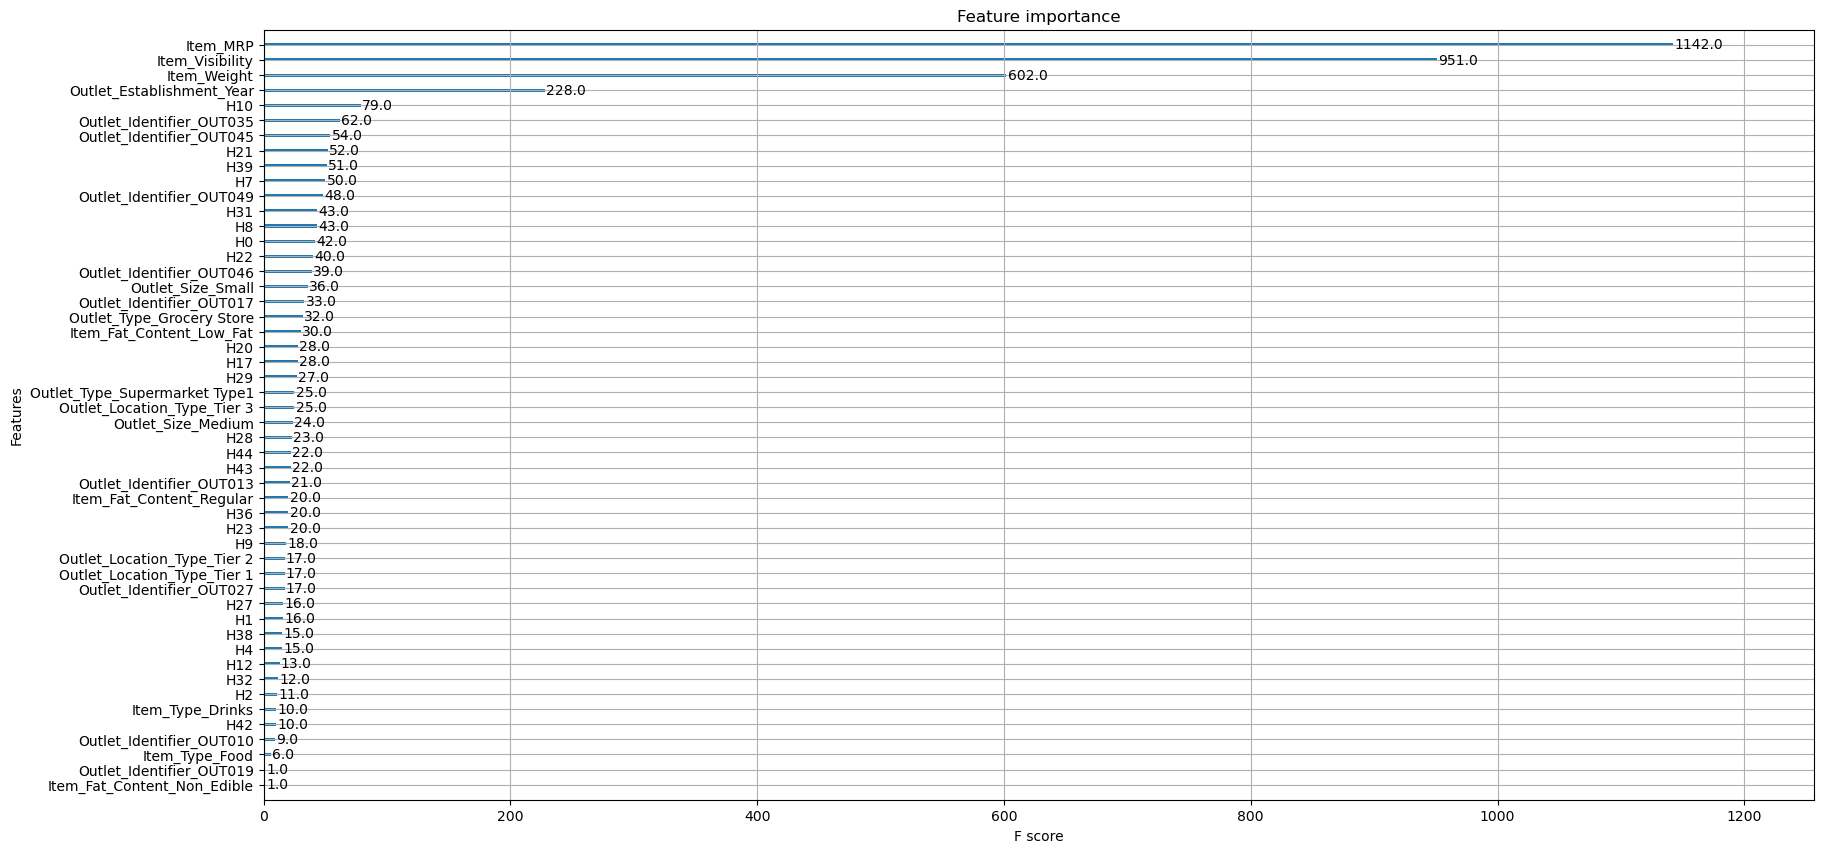

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plot_importance(xgr.get_booster(), ax=ax)  # Plot feature importances
plt.show()